In [38]:
import numpy as np
import cv2
import time
import os
from matplotlib import pyplot as plt
import mediapipe as mp

In [39]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [40]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable= False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [41]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [46]:
# Open the webcam
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
    
        # Read the feed
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
    
        # Make detections 
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_landmarks(image, results)
        
    
        # Show the frame on the screen
        cv2.imshow("OpenCV Feed", image)
    
        # Check if 'q' key is pressed to exit
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()

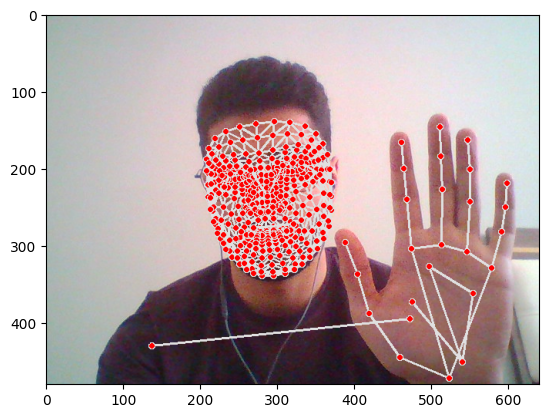

In [47]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [48]:
print(len(results.face_landmarks.landmark))
print(len(results.pose_landmarks.landmark))
print(len(results.left_hand_landmarks.landmark))

468
33
21


In [64]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, left_hand, right_hand])

In [65]:
print(extract_keypoints(results).shape)
print(33*3 + 468*3 + 21*3 + 21*3)

(1629,)
1629
